## Making training data

This notebook describes the workflow for generating training data
from templates

In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import datetime
import models
import platform

from pathlib import Path
from os.path import expanduser
from os import path
import logging

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn_evaluation import plot as sk_plot

import yass
from yass import read_config, preprocess, detect
from yass import util
from yass.augment import make
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage, AutoEncoder 
from yass.explore import RecordingExplorer, SpikeTrainExplorer
from yass.templates import TemplatesProcessor

import numpy as np
from scipy.io import loadmat

from dstools import plot
from dstools.reproducibility import make_filename

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

LOCAL = platform.system() == 'Darwin'

# logging.basicConfig(level=logging.DEBUG)

In [3]:
# for reference
print('YASS version is: {}'.format(util.get_version()))

YASS version is: fe1bd86 updates detect.run to use new separated code


In [9]:
yass.set_config("../config/gcloud/49/default.yaml")

CONFIG = read_config()

In [5]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'nnet')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'ej49_geometry1.txt')

if LOCAL:
    path_to_here = path.expanduser('~/dev/lab/private-yass/nnet')
else:
    path_to_here = path.expanduser('~/dev/private-yass/nnet')

## Loading templates

In [15]:
raw_templates = np.load('/home/Edu/data/templates/cat-good-templates.npy')
raw_templates.shape

(240, 61, 49)

In [17]:
processor = TemplatesProcessor(raw_templates)
templates = (processor
            .crop_spatially(CONFIG.neigh_channels, CONFIG.geom)
            .values)
templates.shape

(240, 61, 7)

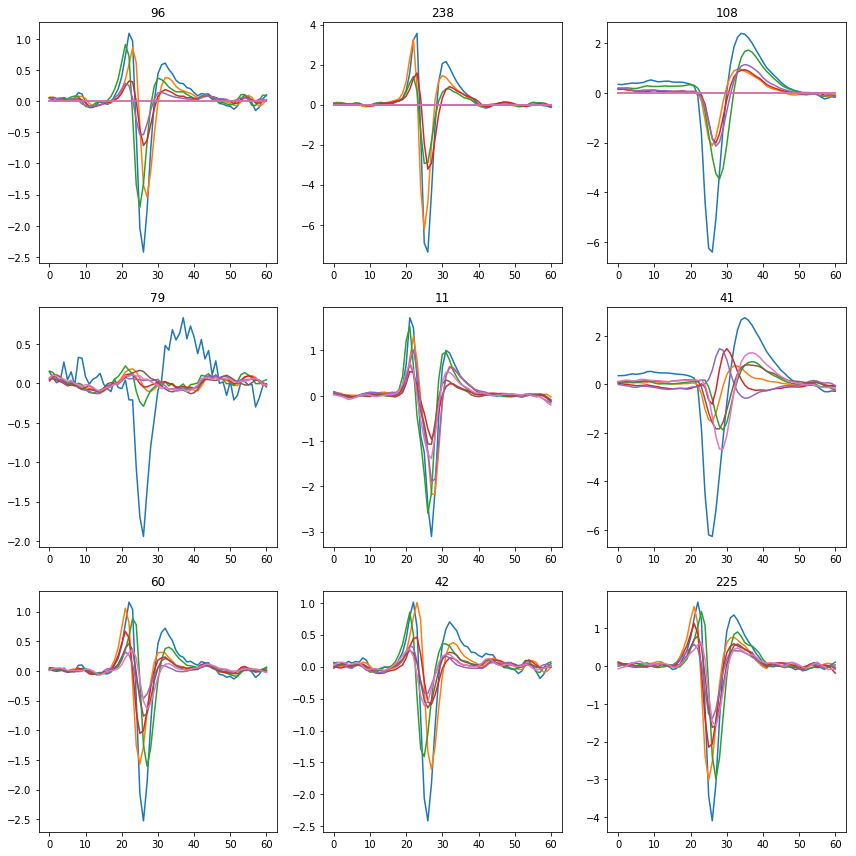

In [22]:
plot.grid_from_array(templates, axis=0, auto_figsize=4,
                     max_cols=3, elements=9)

## Generating training data

In [24]:
n_spikes = 20000
min_amplitude = 2
max_amplitude = 40
noise_ratio = 2
multi_channel = True

In [26]:
(x_detect, y_detect,
 x_triage, y_triage,
 x_ae, y_ae) = make.training_data(CONFIG,
                                  templates,
                                  min_amplitude,
                                  max_amplitude,
                                  n_spikes,
                                  path_to_standarized,
                                  noise_ratio=noise_ratio,
                                  multi_channel=True)

In [30]:
# \n\tautoencoder:{x_ae.shape}
print(f'Training set sizes:\n\tdetect:{x_detect.shape}\n\ttriage:{x_triage.shape}')

Training set sizes:
	detect:(100800, 41, 7)
	triage:(40320, 41, 7)


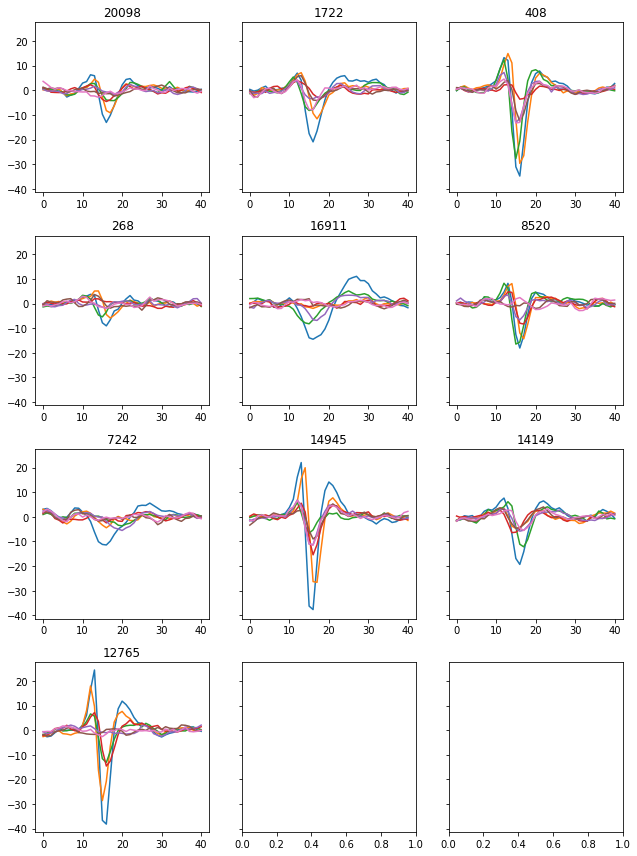

In [31]:
plot.grid_from_array(x_triage[y_triage == 1], axis=0,
                     elements=10,
                     auto_figsize=3, sharey=True)

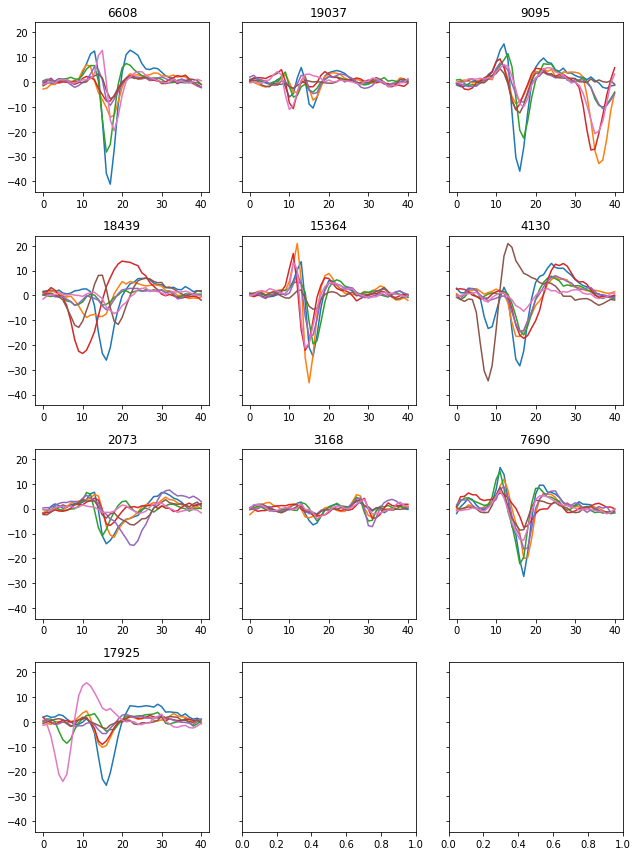

In [32]:
plot.grid_from_array(x_triage[y_triage == 0], axis=0,
                     elements=10,
                     auto_figsize=3, sharey=True)

In [35]:
sufix = make_filename('npy')

x_filename = 'x-triage-'+sufix
y_filename = 'y-triage-'+sufix

In [36]:
np.save('/home/Edu/data/training-sets/'+x_filename, x_triage)
np.save('/home/Edu/data/training-sets/'+y_filename, y_triage)